In [3]:
import pandas as pd
import datetime
import numpy as np
import random
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

In [4]:
bank=pd.read_csv('bank_transactions.csv')
bank=bank.drop('Unnamed: 0',axis=1)

In [5]:
bank

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25.0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,14:18:58,27999.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,18:11:56,1762.5
...,...,...,...,...,...,...,...,...,...
1041609,T1048563,C8020229,1990-08-04,M,NEW DELHI,7635.19,2016-09-18,18:48:24,799.0
1041610,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,18:37:34,460.0
1041611,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,18:33:13,770.0
1041612,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,18:47:06,1000.0


In [6]:
# DROP NA VALUES
bank.dropna(inplace = True)
# TRANFORM IN DATETIME
bank.CustomerDOB = pd.to_datetime(bank.CustomerDOB)

In [7]:
banknew=bank.drop(['TransactionID','CustLocation','TransactionDate','TransactionTime'],axis=1)
# TO DATE 
banknew.CustomerDOB = pd.to_datetime(banknew.CustomerDOB)
# DATE TO YEAR
banknew.CustomerDOB=banknew.CustomerDOB.dt.year
# WE CANNOT FIND A BETTER WAY TO CLEAN DATA SO
# TAKE ONLY THE FIRST ROW FOR EACH CUSTOMERID
banknew=banknew.groupby('CustomerID').first().reset_index() 
banknew

,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionAmount (INR)
0,C1010011,1992,F,32500.73,4750.0
1,C1010012,1994,M,24204.49,1499.0
2,C1010014,1992,F,38377.14,1205.0
3,C1010018,1990,F,496.18,30.0
4,C1010024,1965,M,87058.65,5000.0
...,...,...,...,...,...
879353,C9099836,1990,M,133067.23,691.0
879354,C9099877,1996,M,96063.46,222.0
879355,C9099919,1993,M,5559.75,126.0
879356,C9099941,1995,M,35295.92,50.0


In [8]:
# COUNT PERCENTILE OF BALANCE AND TRANSACTION AMOUNT 
percbal=[]
perctran=[]
for i in range(5,100,5):
    percbal.append(np.percentile(bank.CustAccountBalance,i))
    perctran.append(np.percentile(bank['TransactionAmount (INR)'],i))
percbal=np.asarray([0]+percbal)
perctran=np.asarray([0]+perctran)

In [9]:
# FUNCTION TO SPLIT TRANSACTION AMOUNT IN PERCENTILES
def tagliatran(x):           
    if x>perctran[-1]:      # TO INCREASE THE POSSIBILITY OF THE MATCHING, ASSIGN MORE THE ONE SHINLGE TO EACH ELEMENT   
        return [20,21]
    elif x<perctran[1]:
        return [0,1]
    else:
        ind=np.argmax(perctran>=x)
        return [ind-1,ind,ind+1]

In [10]:
# FUNCTION TO SPLIT BALANCE IN PERCENTILES
def tagliabal(x):
    if x>percbal[-1]:       # TO INCREASE THE POSSIBILITY OF THE MATCHING, ASSIGN MORE THE ONE SHINLGE TO EACH ELEMENT
        return [20,21]
    elif x<percbal[1]:
        return [0,1]
    else:
        ind=np.argmax(percbal>=x)
        return [ind-1,ind,ind+1]

In [11]:
# FUNCTION TO SPLIT DATES OF BIRTH
def tagliaeta(x):
    if x==1800:
        return 0
    else:
        if x<1940:
            return 1
        elif x>=1940 and x<1970:
            return 2
        elif x>=1970 and x<1980:
            return 3
        elif x>=1980 and x<1990:
            return 4
        elif x>=1990 and x<1995:
            return 5
        else:
            return 6

In [12]:
### NEW DATAFRAME PROCESSED WITH THE PREVIOUS FUNCTIONS. THIS DATAFRAME HAVE ONLY THE SHINGLES:
### CUSTOMERID, SEX(0,1), BALANCE(20 SHINGLES), TRANSACTIONAMOUNT(20 SHINLGES), AGE(8 SHINGLES).

data=pd.DataFrame()
data['CustomerID']=banknew.CustomerID
data['CustGender']=banknew.CustGender.apply(lambda x: 0 if x=='M' else 1)
data['CustAccountBalance']=banknew.CustAccountBalance.apply(lambda x: tagliabal(x))
data['TransactionAmount (INR)']=banknew['TransactionAmount (INR)'].apply(lambda x: tagliatran(x))
data['CustomerDOB']=banknew['CustomerDOB'].apply(lambda x: tagliaeta(x))

In [13]:
data

,CustomerID,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerDOB
0,C1010011,1,"[12, 13, 14]","[18, 19, 20]",5
1,C1010012,0,"[11, 12, 13]","[15, 16, 17]",5
2,C1010014,1,"[13, 14, 15]","[15, 16, 17]",5
3,C1010018,1,"[2, 3, 4]","[0, 1, 2]",5
4,C1010024,0,"[16, 17, 18]","[18, 19, 20]",2
...,...,...,...,...,...
879353,C9099836,0,"[17, 18, 19]","[12, 13, 14]",5
879354,C9099877,0,"[16, 17, 18]","[6, 7, 8]",6
879355,C9099919,0,"[5, 6, 7]","[4, 5, 6]",5
879356,C9099941,0,"[13, 14, 15]","[1, 2, 3]",6


# MINHASH

In [14]:
# APPEND EACH SHINGLE IN A LIST AND CREATE A '01' ARRAY 
def riempi01(arr):
    array0=np.zeros(52)
    array = np.append(np.array(arr['CustGender']),np.array(arr['CustAccountBalance'])+2)
    array = np.append(array,np.array(arr['TransactionAmount (INR)'])+23)
    array = np.append(array,np.array(arr['CustomerDOB'])+44)
    array0[array] = 1
    return np.array(array0)

In [15]:
# APPLY THE PREVIOUS FUNCTION TO EACH ROW AND BUILD THE 01 MATRIX OF DATA
mat01 = np.zeros((len(data),52),dtype=('int'))
mat01 = data.apply(riempi01,axis=1)
mat01=np.array(mat01.tolist(),dtype=('int'))

In [16]:
mat01.shape

(879358, 52)

In [17]:
#np.save('mat0152.npy',mat01)
mat01=np.load('mat0152.npy')

In [18]:
### MINHASH migliore
n_perms=24
arr=np.arange(1,mat01.shape[1]+1)                  # ARANGE AN ARRAY OF LENGTH NUMBER OF SHINGLES
matsin=np.zeros((len(data),n_perms),dtype=('int'))   # AND A MATRIX OF ZEROS FOR THE SINGOLAR MATRIX
random.seed(42)
for i in tqdm(range(n_perms)):                     
    random.shuffle(arr)                            # FOR EACH N_PERMS, PERMUTE THE ARRAY THAT REPRESENT THE INDEX OF SHINGLES
    j=1                                  
    while 0 in matsin[:,i]:
        # INDEX IN WHICH THE SHUFFLED ARRAY IS J
        ind=np.where(arr==j)[0][0]              
        
        # FIND THE INDEX IN WHICH 01-MATRIX IS 1 AND THE SINGOLAR MATRIX IS 0
        ind2=np.intersect1d(np.where(mat01[:,ind]==1)[0],np.where(matsin[:,i]==0)[0],assume_unique=True)
        
        # IN THAT INDEXES PUT J 
        matsin[ind2,i]=j
        
        j+=1     

100%|██████████| 24/24 [00:22<00:00,  1.09it/s]


In [22]:
#np.save('matsin24.npy', matsin)
matsin=np.load('matsin24.npy')

In [23]:
matsin

array([[ 2,  2,  4, ...,  5,  9,  4],
       [ 2,  8,  2, ...,  1,  2,  4],
       [ 2,  2,  2, ...,  4,  2,  4],
       ...,
       [ 2,  1,  6, ..., 11,  1,  3],
       [ 5,  2,  7, ...,  4, 18,  9],
       [ 3,  4, 20, ..., 12,  1,  6]])

# Riempi buckets

In [24]:
### HASH FUNCTION:
def hashfun(x,vet,vet1):
    return(np.dot(vet1*x,vet) % 1099957)
    
### FILL BUCKETS FUNCTION:
def fillbuc(mat,coldorsl,band): # (singolar matrix, n. rows for band, n. of the band)
    bucket={}
    row,col=mat.shape
    random.seed(42)
    vet=random.sample(range(1000000,100000000), coldorsl)
    vet1=random.sample(range(1000000,100000000), coldorsl)
    # TAKE THE BAND
    matwork=mat[:,coldorsl*band:coldorsl*(band+1)]         
        
    bucket={}
    for i in range(row):
        ele=hashfun(matwork[i,:],vet,vet1)  # APPLY HASHFUNCTION ON THE COLOUMNS OF THE BANDS
        if ele in bucket.keys():            # IF THERE ISN'T A BUCKET WITH THIS INDEX, BUILD IT
            bucket[ele].append(i)
        else:
            bucket[ele]=[]
            bucket[ele].append(i)

    return bucket

In [25]:
colforsl=2                                           # columns for each slice
bands=int(matsin.shape[1]/colforsl)                  # number of bands
allbuck2={}
for i in tqdm(range(bands)):                         # for each slice build the buckets
    allbuck2[i]=fillbuc(matsin,colforsl,i)       

100%|██████████| 12/12 [00:44<00:00,  3.70s/it]


In [26]:
colforsl=3                                           # columns for each slice
bands=int(matsin.shape[1]/colforsl)                  # number of slices
allbuck3={}
for i in tqdm(range(bands)):                         # for each slice build the buckets
    allbuck3[i]=fillbuc(matsin,colforsl,i)       

100%|██████████| 8/8 [00:28<00:00,  3.60s/it]


In [27]:
colforsl=4                                           # columns for each slice
bands=int(matsin.shape[1]/colforsl)                  # number of slices
allbuck4={}
for i in tqdm(range(bands)):                         # for each slice build the buckets
    allbuck4[i]=fillbuc(matsin,colforsl,i)       

100%|██████████| 6/6 [00:22<00:00,  3.72s/it]


In [28]:
colforsl=6                                           # columns for each slice
bands=int(matsin.shape[1]/colforsl)                  # number of slices
allbuck6={}
for i in tqdm(range(bands)):                         # for each slice build the buckets
    allbuck6[i]=fillbuc(matsin,colforsl,i)       

100%|██████████| 4/4 [00:15<00:00,  3.94s/it]


In [29]:
colforsl=8                                           # columns for each slice
bands=int(matsin.shape[1]/colforsl)                  # number of slices
allbuck8={}
for i in tqdm(range(bands)):                         # for each slice build the buckets
    allbuck8[i]=fillbuc(matsin,colforsl,i)       

100%|██████████| 3/3 [00:12<00:00,  4.16s/it]


In [30]:
colforsl=12                                           # columns for each slice
bands=int(matsin.shape[1]/colforsl)                   # number of slices
allbuck12={}
for i in tqdm(range(bands)):                          # for each slice build the buckets
    allbuck12[i]=fillbuc(matsin,colforsl,i)       

100%|██████████| 2/2 [00:09<00:00,  4.55s/it]


In [31]:
allbuck={}         # ALLBUCK CONTEIN ALL THE BUCKETS
allbuck[2]=allbuck2
allbuck[3]=allbuck3
allbuck[4]=allbuck4
allbuck[6]=allbuck6
allbuck[8]=allbuck8
allbuck[12]=allbuck12

In [24]:
### QUANTI BUCKETS IN MEDIA
mediabucket2=0
mediabucket3=0
mediabucket4=0
mediabucket6=0
mediabucket8=0
mediabucket12=0

for i in range(12):                # FOR EACH SLICE COUNT HOW MANY BUCKETS 
    mediabucket2+=len(allbuck2[i])
mediabucket2=mediabucket2/12       # MEAN OF BUCKETS (for slices)

for i in range(8):
    mediabucket3+=len(allbuck3[i])
mediabucket3=mediabucket3/8

for i in range(6):
    mediabucket4+=len(allbuck4[i])
mediabucket4=mediabucket4/6

for i in range(4):
    mediabucket6+=len(allbuck6[i])
mediabucket6=mediabucket6/4

for i in range(3):
    mediabucket8+=len(allbuck8[i])
mediabucket8=mediabucket8/3

for i in range(2):
    mediabucket12+=len(allbuck12[i])
mediabucket12=mediabucket12/2

In [25]:
### QUANTI ELEMENTI CI SONO IN CIASCUN BUCKET IN MEDIA
mediaele2=0
mediaele3=0
mediaele4=0
mediaele6=0
mediaele8=0
mediaele12=0


for i in range(12):                      # FOR EACH SLICE
    for j in allbuck2[i]:                # FOR EACH BUCKET
        mediaele2+=len(allbuck2[i][j])   # HOW MANY ELEMENTS FOR BUCKET
mediaele2=mediaele2/(mediabucket2*12)    # MEAN OF ELEMENTS FOR BUCKET (tot elements/(mean bucket* num slices))
    
for i in range(8):
    for j in allbuck3[i]:
        mediaele3+=len(allbuck3[i][j])
mediaele3=mediaele3/(mediabucket3*8)

for i in range(6):
    for j in allbuck4[i]:
        mediaele4+=len(allbuck4[i][j])
mediaele4=mediaele4/(mediabucket4*6)

for i in range(4):
    for j in allbuck6[i]:
        mediaele6+=len(allbuck6[i][j])
mediaele6=mediaele6/(mediabucket6*4)

for i in range(3):
    for j in allbuck8[i]:
        mediaele8+=len(allbuck8[i][j])
mediaele8=mediaele8/(mediabucket8*3)

for i in range(2):
    for j in allbuck12[i]:
        mediaele12+=len(allbuck12[i][j])
mediaele12=mediaele12/(mediabucket12*2)

# MEAN OF THE ELEMENTS, GIVEN THE ROWS IN BANDS

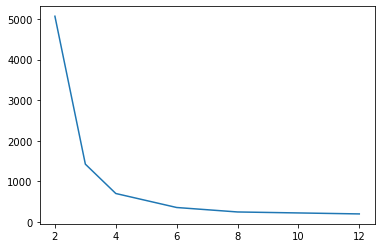

In [26]:
plt.plot([2,3,4,6,8,12], [mediaele2,mediaele3,mediaele4,mediaele6,mediaele8,mediaele12])

In [27]:
[mediaele2,mediaele3,mediaele4,mediaele6,mediaele8,mediaele12]

[5068.681265206813,
 1424.6729355445375,
 701.7386031888615,
 356.8087693756958,
 246.78897488548412,
 198.74336958595688]

The plot is in log-scale because the mean number of elements in each bucket decrease very fast reducing the number of rows for bands

# MEAN OF THE BUCKETS, GIVEN THE ROWS IN BANDS

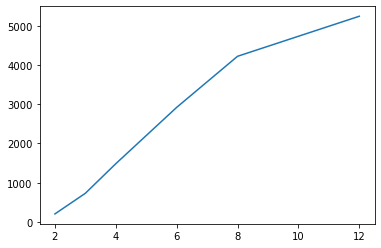

In [28]:
plt.plot([2,3,4,6,8,12], [mediabucket2,mediabucket3,mediabucket4,mediabucket6,mediabucket8,mediabucket12])

In [29]:
[mediabucket2,mediabucket3,mediabucket4,mediabucket6,mediabucket8,mediabucket12]

[205.5, 731.125, 1484.3333333333333, 2919.25, 4220.666666666667, 5241.0]

Converserly the number of buckets grows.

# MEAN OF THE DIFFERENT VALUES, GIVEN THE ROWS IN THE BANDS


In [32]:
data.Balance=data.Balance.apply(lambda x: str(x))
data.Transaction=data.Transaction.apply(lambda x: str(x))
# data.Balance=data.Balance.apply(lambda x: eval(x))
# data.Transaction=data.Transaction.apply(lambda x: eval(x))

In [31]:
num2=0
num3=0
num4=0
num6=0
num8=0
num12=0


for j in tqdm(allbuck2):                                                          # FOR EACH BANDS
    for i in allbuck2[j].keys():                                                  # FOR EACH BUCKETS
        num2+=len(data.loc[allbuck2[j][i]].drop('CustId',axis=1).value_counts())  # COUNT HOW MANY DIFFERENT VALUE
num2=num2/(mediabucket2*12)                                                       # DIVIDE FOR NUMBER OF BUCKETS


for j in tqdm(allbuck3):
    for i in allbuck3[j].keys():
        num3+=len(data.loc[allbuck3[j][i]].drop('CustId',axis=1).value_counts())
        
num3=num3/(mediabucket3*8)


for j in tqdm(allbuck4):
    for i in allbuck4[j].keys():
        num4+=len(data.loc[allbuck4[j][i]].drop('CustId',axis=1).value_counts())
        
num4=num4/(mediabucket4*6)


for j in tqdm(allbuck6):
    for i in allbuck6[j].keys():
        num6+=len(data.loc[allbuck6[j][i]].drop('CustId',axis=1).value_counts())
        
num6=num6/(mediabucket6*4)


for j in tqdm(allbuck8):
    for i in allbuck8[j].keys():
        num8+=len(data.loc[allbuck8[j][i]].drop('CustId',axis=1).value_counts())
        
num8=num8/(mediabucket8*3)


for j in tqdm(allbuck12):
    for i in allbuck12[j].keys():
        num12+=len(data.loc[allbuck12[j][i]].drop('CustId',axis=1).value_counts())
    
num12=num12/(mediabucket12*2)

 38%|███▊      | 3/8 [00:13<00:21,  4.37s/it]


KeyboardInterrupt: 

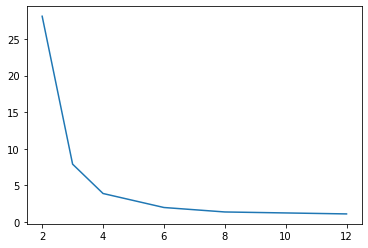

In [147]:
plt.plot([2,3,4,6,8,12], [num2,num3,num4,num6,num8,num12])

In [148]:
[num2,num3,num4,num6,num8,num12]

[28.092457420924575,
 7.896050606941357,
 3.889288120368291,
 1.9775627301532928,
 1.367793397567525,
 1.10150734592635]

The mean of different elements decrease very fast, we have a sort of 'helbow' effect in 4, maybe this is due to the fact we are considering only 4 features.

# Query

In [32]:
query=pd.read_csv('query_users.csv')

In [33]:
# QUERYNEW => DROP COLOUMS AND TAKE ONLY YEAR INSTEAD THE DATE
querynew=pd.DataFrame()
querynew=query.drop(['CustLocation','TransactionDate','TransactionTime'],axis=1)
querynew.CustomerDOB = pd.to_datetime(query.CustomerDOB)
querynew.CustomerDOB=querynew.CustomerDOB.dt.year

In [34]:
querynew

,CustomerDOB,CustGender,CustAccountBalance,TransactionAmount (INR)
0,1978,M,94695.61,65.00
1,1992,M,7584.09,6025.00
2,1991,M,7180.60,541.50
3,1987,M,56847.75,1000.00
4,1995,M,84950.13,80.00
5,1981,M,23143.95,303.00
6,1976,F,15397.80,20.00
7,1991,M,426.30,50.00
8,1990,M,4609.34,300.00
9,2070,M,6695988.46,299.00


In [35]:
# QUERYPRO => TRADUCE QUERYNEW IN SHINGLES
querypro=pd.DataFrame()
querypro['Gender']=query.CustGender.apply(lambda x: 0 if x=='M' else 1)
querypro['Balance']=query.CustAccountBalance.apply(lambda x: tagliabal(x))
querypro['Transaction']=query['TransactionAmount (INR)'].apply(lambda x: tagliatran(x))
querypro['Age']=pd.to_datetime(query['CustomerDOB']).dt.year.apply(lambda x: tagliaeta(x))

In [36]:
querypro

,Gender,Balance,Transaction,Age
0,0,"[16, 17, 18]","[2, 3, 4]",3
1,0,"[6, 7, 8]","[20, 21]",5
2,0,"[6, 7, 8]","[11, 12, 13]",5
3,0,"[14, 15, 16]","[13, 14, 15]",4
4,0,"[16, 17, 18]","[2, 3, 4]",6
5,0,"[11, 12, 13]","[8, 9, 10]",4
6,1,"[9, 10, 11]","[0, 1]",3
7,0,"[1, 2, 3]","[1, 2, 3]",5
8,0,"[4, 5, 6]","[7, 8, 9]",5
9,0,"[20, 21]","[7, 8, 9]",6


In [42]:
# QUERY'S MATRIX01
matquery = np.zeros((50,52),dtype=('int'))   
for i in tqdm(range(len(querypro))):
    matquery[i,[querypro.loc[i]['Gender'],querypro.loc[i]['Balance'][0]+2,querypro.loc[i]['Balance'][1]+2,querypro.loc[i]['Transaction'][0]+23,querypro.loc[i]['Transaction'][1]+23,querypro.loc[i]['Age']+44]]=1

100%|██████████| 50/50 [00:00<00:00, 1618.31it/s]


In [43]:
matquery.shape

(50, 52)

In [44]:
# QUERY'S SINGOLAR MATRIX (AS WE JUST DO FOR THE WHOLE DATASET)
n_perms=24
arr=np.arange(1,matquery.shape[1]+1)
matquerysin=np.zeros((50,n_perms),dtype=('int'))
random.seed(42)
for i in tqdm(range(n_perms)):
    random.shuffle(arr)
    j=1
    while 0 in matquerysin[:,i]:
        try:
            ind=np.where(arr==j)[0][0]
            ind2=np.intersect1d(np.where(matquery[:,ind]==1)[0],np.where(matquerysin[:,i]==0)[0],assume_unique=True)
            matquerysin[ind2,i]=j
        except:
            pass
        j+=1 

100%|██████████| 24/24 [00:00<00:00, 1719.95it/s]


In [45]:
matquerysin

array([[10,  3,  3, ...,  6, 11,  5],
       [ 2,  4, 19, ..., 13,  1,  4],
       [ 2,  4,  1, ..., 13,  1,  4],
       ...,
       [ 2,  6,  7, ...,  7, 18,  4],
       [ 2,  4, 10, ..., 14,  1,  4],
       [10, 11, 18, ..., 12,  5,  3]])

In [46]:
# AFTER HAVE FOUND THE CANDIDATES WITH THE MINHASH, I WANT TO MEASURE THEIR DISTANCE FROM  THE QUERY 
# WITH AN OTHER DISTANCE ON THE BANKNEW DATASET (WHERE THERE ARE THE TRUE VALUE FOR EACH FEATURE)
# TO CHECK HOW MANY FALSE POSITIVE THERE ARE AND SO HOW GOOD IS THE MINHASH.

def misura(qdoc,doc):
    
    queryline = querynew.loc[qdoc]
    
    docline = banknew.loc[doc]
    
    misdata = 1 - pow((abs( queryline.CustomerDOB - docline.CustomerDOB )) / max( queryline.CustomerDOB, docline.CustomerDOB ),1/2)
    
    misbalance = 1 - pow((abs(queryline.CustAccountBalance - docline.CustAccountBalance) / max(queryline.CustAccountBalance,docline.CustAccountBalance) ),1/2)
    
    mistrans = 1 - (abs(queryline['TransactionAmount (INR)'] - docline['TransactionAmount (INR)']) / max( queryline['TransactionAmount (INR)'],docline['TransactionAmount (INR)'] ))
    
    mis = misdata * misbalance * mistrans
    
    if queryline.CustGender!=docline.CustGender:
        mis=mis * 0.80
        
    return mis

In [47]:
def findque(que,coldorsl):
    assert coldorsl in [2,3,4,6,8,12]       # ROWS IN BAND HAVE TO BE IN [2,3,4,6,8,12]
    random.seed(42)
    vet=random.sample(range(1000000,100000000), coldorsl)
    vet1=random.sample(range(1000000,100000000), coldorsl)
    # APPLY HASHFUNCTION ON EACH BAND
    ind=[hashfun(que[coldorsl*i:coldorsl*(i+1)],vet,vet1) for i in range(que.shape[0]//coldorsl)]
    return ind

In [48]:
findque(matquerysin[0],3)

[313000, 455822, 299686, 83245, 106922, 274026, 837638, 569886]

In [49]:
def trova(qdoc,coldorsl):
    ind=findque(matquerysin[qdoc],coldorsl)    # TAKE THE INDEXES OF THE BUCKETS IN WHICH QUERY IS
    
    buck=allbuck[coldorsl]                    

    docsim=set()
    
    for i in buck:                             # TAKE THE UNION OF THE BUCKETS WHICH THE QUERY BELONG
        try:
            docsim.update(buck[i][ind[i]])
        except:
            pass
    
    docsim=sorted(list(docsim))                # SORT THE INDEXES OF THE CANDIDATE TRANSACTIONS 
    a=[misura(qdoc,i) for i in docsim]         # FOR EACH CANDITATES TAKE DISTANCE WHICH QUERY
        
    b = banknew[banknew.index.isin(docsim)]
    b = b.assign(SIM=a)
    
    falsipos=sum(b['SIM']<0.70)/len(b)         # GIVEN A THRESHOLD, TAKE THE FALSE POSITIVE
    positivi=sum(b['SIM']>=0.70)               # AND THE NUMBER OF THE POSITIVE
    
    print('(THRESHOLD = 0.70)\n POSITIVE: '+str(positivi)+'\n FALSE POSITIVE: '+str(falsipos)+'\n TOTAL: '+str(len(b)))
    
    return b.sort_values(by='SIM',ascending=False).head(20) # SORT BY THE SIMILARITY

In [50]:
trova(1,2)

(THRESHOLD = 0.70)
 POSITIVE: 93
 FALSE POSITIVE: 0.9992656116744054
 TOTAL: 126636


,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionAmount (INR),SIM
242576,C3224067,1992,M,7584.09,6025.00,1.000000
583209,C6341145,1985,M,7628.02,5974.00,0.861972
637820,C6841847,1979,M,7557.47,6000.00,0.861168
814984,C8513588,1991,M,7547.52,5700.00,0.860639
496959,C5542280,1989,M,7676.98,6047.00,0.852350
439406,C5029979,1991,M,7468.63,6068.00,0.850901
269521,C3446646,1994,M,7563.55,6500.00,0.850857
383677,C4523852,1990,M,7533.19,5743.00,0.847377
569324,C6230242,1992,M,7581.68,7000.00,0.845371
710974,C7530239,1992,M,7581.68,7000.00,0.845371


In [55]:
Look how the search engine works: search the candidates to each query, using the different bands to check:
        1. how many candidates are found;
        2. how many dist more then 0.70 from the query;
        3. how many time it spends.

SyntaxError: invalid syntax (3475571524.py, line 1)

In [53]:
def trovaall(qdoc,coldorsl):
    start=time.time()
    ind=findque(matquerysin[qdoc],coldorsl)    # TAKE THE INDEXES OF THE BUCKETS IN WHICH QUERY IS
    
    buck=allbuck[coldorsl]                    

    docsim=set()
    
    for i in buck:                             # TAKE THE UNION OF THE BUCKETS WHICH THE QUERY BELONG
        try:
            docsim.update(buck[i][ind[i]])
        except:
            pass
    
    docsim=sorted(list(docsim))                # SORT THE INDEXES OF THE CANDIDATE TRANSACTIONS 
    a=[misura(qdoc,i) for i in docsim]         # FOR EACH CANDITATES TAKE DISTANCE WHICH QUERY
        
    b = banknew[banknew.index.isin(docsim)]
    b = b.assign(SIM=a)
    
    positivi=sum(b['SIM']>=0.70)               # AND THE NUMBER OF THE POSITIVE
    
    end=time.time()
        
    return len(b),positivi,end-start

In [54]:
# CHECK HOW MANY TOTAL CANDIDATES, HOW MANY CANDIDATES ARE 'NEAR' THE QUERY
# AND HOW MUCH TIME TAKE THIS ALGORITHM FOR EACH QUERY AND USING DIFFERENT BANDS
# (FOR US 'NEAR' MEANS SIM(QUERY,CANDIDATE)>=0.70)
#temps=np.matrix((6,len(query)))
ris={}
for j in [2,3,4,6,8,12]:
    ris[j]={}
    for i in tqdm(range(len(query))):
        ris[j][i]=trovaall(i,j)
        

100%|██████████| 50/50 [00:01<00:00, 37.50it/s]


In [56]:
ris

{2: {0: (177886, 81, 34.6012761592865),
  1: (126636, 93, 23.2185800075531),
  2: (155580, 1011, 28.998903036117554),
  3: (222742, 1148, 40.05863547325134),
  4: (167531, 97, 34.04017472267151),
  5: (148453, 1200, 28.89226007461548),
  6: (44490, 65, 8.3980233669281),
  7: (89154, 178, 17.836453676223755),
  8: (61904, 968, 15.93578314781189),
  9: (43513, 0, 9.079479694366455),
  10: (137009, 1044, 29.834559679031372),
  11: (148289, 54, 27.377792358398438),
  12: (149156, 850, 28.9405460357666),
  13: (93124, 106, 16.664069414138794),
  14: (166480, 1296, 31.40394163131714),
  15: (34662, 278, 9.013187885284424),
  16: (125267, 133, 30.22478175163269),
  17: (172350, 69, 32.51078987121582),
  18: (177541, 335, 34.54480838775635),
  19: (113986, 752, 22.880406141281128),
  20: (99556, 8, 17.916873693466187),
  21: (174750, 30, 32.09072685241699),
  22: (146554, 409, 29.79313039779663),
  23: (200408, 37, 37.62320899963379),
  24: (124157, 525, 22.774349212646484),
  25: (131289, 775

In [57]:
cand=np.zeros(13)
pos=np.zeros(13)
temp=np.zeros(13)
for i in ris:
    for j in ris[i]:
        cand[i]+=ris[i][j][0]
        pos[i]+=ris[i][j][1]
        temp[i]+=ris[i][j][2]
cand=cand/50
pos=pos/50
temp=temp/50


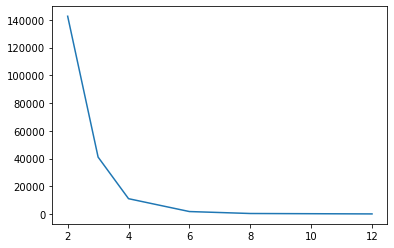

In [58]:
plt.plot([2,3,4,6,8,12], cand[cand>0])

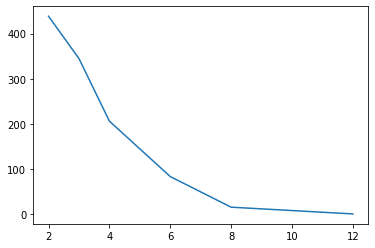

In [59]:
plt.plot([2,3,4,6,8,12], pos[pos>0])

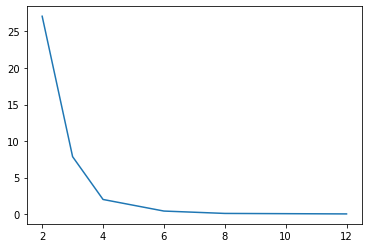

In [60]:
plt.plot([2,3,4,6,8,12], temp[temp>0])

In [ ]:
The canditades, in mean, are a lot which two rows, and decrease fast until 4: i think 4 could be the best number of rows, also for the number of elements that have a distance more then 0.70 and for the time.